2025-05-03 21:52:16.180138: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Lab Distribution:
target
0.0    464748
1.0     15450
Name: count, dtype: int64
Epoch 1/200
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - auc: 0.5671 - f1_score: 0.4732 - loss: 0.1364 - val_auc: 0.7466 - val_f1_score: 0.1170 - val_loss: 0.0660 - learning_rate: 1.0000e-04
Epoch 2/200
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - auc: 0.6649 - f1_score: 0.5370 - loss: 0.0953 - val_auc: 0.7679 - val_f1_score: 0.1206 - val_loss: 0.0604 - learning_rate: 1.0000e-04
Epoch 3/200
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - auc: 0.7030 - f1_score: 0.5742 - loss: 0.0835 - val_auc: 0.7774 - val_f1_score: 0.1224 - val_loss: 0.0574 - learning_rate: 1.0000e-04
Epoch 4/200
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - auc: 0.7346 - f1_score: 0.5974 - loss: 0.0775 - val_auc: 0.7831 - val_f1_score: 0.1210 - val_loss: 0.0569 - learning_rate: 1.0000e-04
Epoch 5/200
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - auc: 0.7607 - f1_score: 0.6245 - loss: 0.0740 - val_auc: 0.7866 - val_f1_score: 0.1242 - val_l

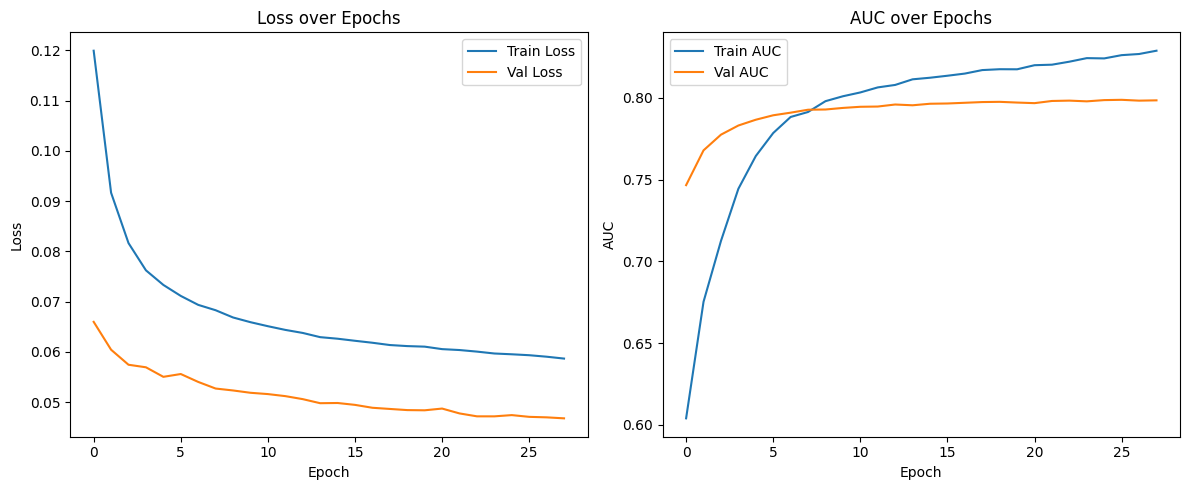

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import ADASYN


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.losses import Loss
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 


@register_keras_serializable()
class BinaryFocalLoss(Loss):
    def __init__(self, gamma=2.0, alpha=0.7, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(self.alpha * K.pow(1. - pt_1, self.gamma) * K.log(pt_1)) \
               -K.mean((1 - self.alpha) * K.pow(pt_0, self.gamma) * K.log(1. - pt_0))

    def get_config(self):
        return {"gamma": self.gamma, "alpha": self.alpha}
    
@register_keras_serializable()
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_bin = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        self.tp.assign_add(tf.reduce_sum(y_true * y_pred_bin))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred_bin))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred_bin)))

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        recall = self.tp / (self.tp + self.fn + 1e-8)
        return 2 * precision * recall / (precision + recall + 1e-8)

    def reset_states(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)

    def get_config(self):
        return {'threshold': self.threshold}


df = pd.read_parquet("../data/train_data.parquet")


categorical_cols = df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))


drop_cols = ["case_id", "date_decision", "target"]
X = df.drop(columns=drop_cols)
y = df["target"]


print("Lab Distribution:")
print(y.value_counts())


X_train_raw, X_test_raw, y_train_raw, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


pipeline = Pipeline([
    ('undersample', RandomUnderSampler(sampling_strategy=0.2, random_state=42)),  
    ('oversample', ADASYN(sampling_strategy=0.5, random_state=42))                
])
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_raw, y_train_raw)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled).astype(np.float32)
X_test_scaled = scaler.transform(X_test_raw).astype(np.float32)

joblib.dump(scaler, "../output/model/scaler.pkl")


y_train = y_train_resampled.astype(np.float32)
y_test = y_test.astype(np.float32)


model = Sequential([
    Dense(64, kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),

    Dense(32, kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),

    Dense(1, activation='sigmoid')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=BinaryFocalLoss(gamma=2.0, alpha=0.7),
    metrics=[F1Score(name='f1_score'), AUC(name="auc")]
)


rlr = ReduceLROnPlateau(monitor='val_f1_score', factor=0.1, patience=5,
                        verbose=1, min_delta=1e-4, mode='max')

early_stop = EarlyStopping(monitor='val_f1_score', mode='max', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint("../output/model/nn_best_model.keras",
                             monitor='val_f1_score', mode='max', save_best_only=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=200,
    batch_size=64,
    callbacks=[rlr, early_stop, checkpoint],
    verbose=1
)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


2960/2960 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


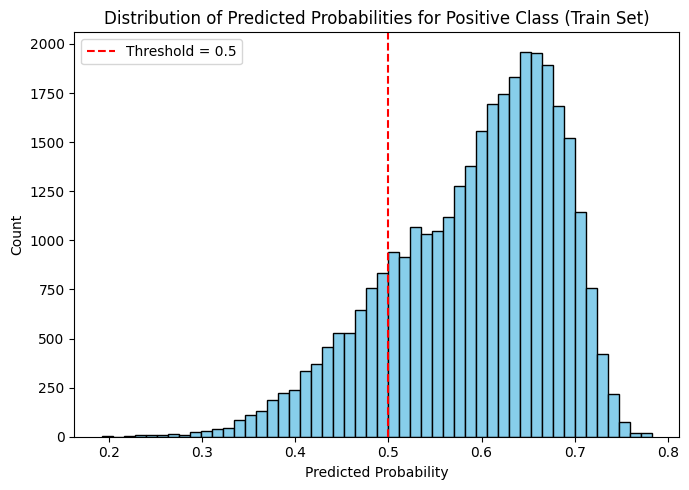

In [2]:
y_train_true = y_train_resampled
X_train_input = X_train_scaled  


y_train_pred_prob = model.predict(X_train_input).flatten()


pos_probs = y_train_pred_prob[y_train_true == 1]


import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.hist(pos_probs, bins=50, color='skyblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.title("Distribution of Predicted Probabilities for Positive Class (Train Set)")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
import numpy as np
import pandas as pd

epsilon = 1e-6

df['EAD'] = df['residualamount_856A_mean'] + df['currdebt_22A']
df['LGD'] = 1 - df['collater_valueofguarantee_1124L_sum'] / (df['EAD'] + epsilon)
df['LGD'] = df['LGD'].clip(lower=0, upper=1)

alpha1 = 0.02
alpha2 = 0.001
linear_score = (
    alpha1 * df['maxdpdlast6m_474P'].fillna(0) +
    alpha2 * df['pmts_overdue_1140A_mean'].fillna(0)
)
df['PD'] = 1 / (1 + np.exp(-linear_score))
df['ELI_raw'] = df['EAD'] * df['LGD'] * df['PD']
min_eli, max_eli = df['ELI_raw'].min(), df['ELI_raw'].max()
df['ELI'] = (df['ELI_raw'] - min_eli) / (max_eli - min_eli + epsilon)

df['BI_raw'] = df['residualamount_856A_mean'] * df['nominalrate_281L_max']
min_bi, max_bi = df['BI_raw'].min(), df['BI_raw'].max()
df['BI'] = (df['BI_raw'] - min_bi) / (max_bi - min_bi + epsilon)

summary = df.groupby('target').agg({
    'ELI': 'mean',
    'BI': 'mean',
    'case_id': 'count'
}).rename(index={0: 'Good User (0)', 1: 'Bad User (1)'})
summary.columns = ['Avg_Loss_Index (ELI)', 'Avg_Benefit_Index (BI)', 'User_Count']

print("Average economic impact by customer type:")
print(summary)

results = df[['case_id', 'target', 'ELI', 'BI']]

avg_loss = summary.loc['Bad User (1)', 'Avg_Loss_Index (ELI)']
avg_benefit = summary.loc['Good User (0)', 'Avg_Benefit_Index (BI)']
break_even_good_ratio = avg_loss / (avg_benefit + avg_loss + epsilon)

print(f"\n Minimum required proportion of good users for break-even: {break_even_good_ratio:.2%}")



Average economic impact by customer type:
               Avg_Loss_Index (ELI)  Avg_Benefit_Index (BI)  User_Count
target                                                                 
Good User (0)              0.037713                0.026243      464748
Bad User (1)               0.054642                0.040812       15450

 Minimum required proportion of good users for break-even: 67.55%


In [10]:
from sklearn.metrics import confusion_matrix
import numpy as np

thresholds = np.linspace(0.00, 1.00, 1000)

profit_per_good = 0.026243 * 10000
loss_per_bad = 0.054642 * 10000

min_total_cost = float('inf')
best_threshold = None

for thresh in thresholds:
    y_pred = (y_train_pred_prob >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    cost = fp * profit_per_good + fn * loss_per_bad

    if cost < min_total_cost:
        min_total_cost = cost
        best_threshold = thresh

print(f" Optimal threshold minimizing economic cost: {best_threshold:.3f}")
print(f" Minimum total cost: ${min_total_cost:,.0f}")



 Optimal threshold minimizing economic cost: 0.504
 Minimum total cost: $7,877,290
